In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst.traces import philly
from skyburst.traces import philly_utils

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

def load_logs(file_path: str):
    file = open(file_path)
    return pickle.load(file)

In [2]:
def create_results_df(simulator_results: dict, waiting_policy='linear'):
    results_df = pd.DataFrame({'alg': pd.Series(dtype='str'),
                   'size': pd.Series(dtype='int'),
                   'cost': pd.Series(dtype='float'),
                   'waiting_time': pd.Series(dtype='float'),
                   'waiting_policy': pd.Series(dtype='float')})
    algs = []
    num_nodes_list = []
    cloud_costs = []
    waiting_times = []
    for key, finished_jobs in simulator_results.items():
        token_list = key.split('-')
        if len(token_list)>0:
            alg =  '-'.join(token_list[:-1])
            num_nodes = token_list[-1]
        else:
            alg = f'{token_list[0]}-{token_list[1]}'
            num_nodes = token_list[2]
        num_nodes = int(num_nodes)
        cloud_cost = 0.0
        total_waiting_time = 0.0
        count = 0
        for idx in range(len(finished_jobs['idx'])):
            if idx < 2000 or idx > len(finished_jobs['idx']) - 2000:
                continue
            arrival = finished_jobs['arrival'][idx]
            start = finished_jobs['start'][idx]
            # Handle legacy data
            if finished_jobs['state'][idx] != 'LOCAL':
                runtime = finished_jobs['runtime'][idx]
                cloud_cost += finished_jobs['num_gpus'][idx] * runtime
                if finished_jobs['state'][idx] == 'FILTER-CLOUD':
                    total_waiting_time += start - arrival
                else:
                    deadline = finished_jobs['deadline'][idx]
                    total_waiting_time += deadline - runtime - arrival
            else:
                total_waiting_time += start - arrival
            count+=1
        avg_waiting_time = total_waiting_time / count
        df = pd.DataFrame(data={'alg': [alg], 'size': [num_nodes], 'cost': [cloud_cost], 'waiting_time': [avg_waiting_time], 'waiting_policy': [waiting_policy]})
        results_df = pd.concat([results_df, df], ignore_index=True)
    return results_df

def plot_cost_and_waiting_graph(results_df, normalized=False, plot_twin=True):
#     options = ['fifo', 'lifo', 'lifo-nohol']
#     results_df = results_df[results_df['alg'].isin(options)]
    if plot_twin:
        fig, ax = plt.subplots()
        ax2 = ax.twinx()
    else:
        # Get current default figsize
        default_figsize = plt.rcParams.get('figure.figsize')
        # Set the new figsize as the default
        fix, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2*default_figsize[0], 2*default_figsize[1]))
        
    if normalized:
        x_axis = 'norm_size'
        label_x = 'Input rate/ Cluster capacity'
        total_job_gpu_hours = 1155998.77277777
        job_makespan = 2559.3205555555555
        results_df[x_axis] = total_job_gpu_hours/(job_makespan*results_df['size']*8)
    else:
        x_axis = 'size'
        label_x = '# of Cluster Node(s)'
    
    for idx, (label, grp) in enumerate(results_df.groupby('alg')):
        a1 = grp.plot(x = x_axis, y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel=label_x, \
                ylabel='Cloud Price')
        if plot_twin:
            style = '--'
        else:
            style = None
        a2 = grp.plot(x = x_axis, y = 'waiting_time', ax = ax2, marker='v', label = label, legend=None, xlabel=label_x, \
                      ylabel = 'Avg. Waiting Time', style=style)
    ax.set_ylim(bottom=0.0)
    
    if plot_twin:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, ncol=len(labels) + len(labels2), \
                  bbox_to_anchor=(0, 1.00, 1, 0.2), loc="upper left")
        ax.grid(True, which='both')
    else:
        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, ncol=len(labels), \
                  bbox_to_anchor=(0, 0.90, 1, 0.2), loc="upper left")
        ax.grid(True, which='both')
        ax2.grid(True, which='both')
    plt.show()  

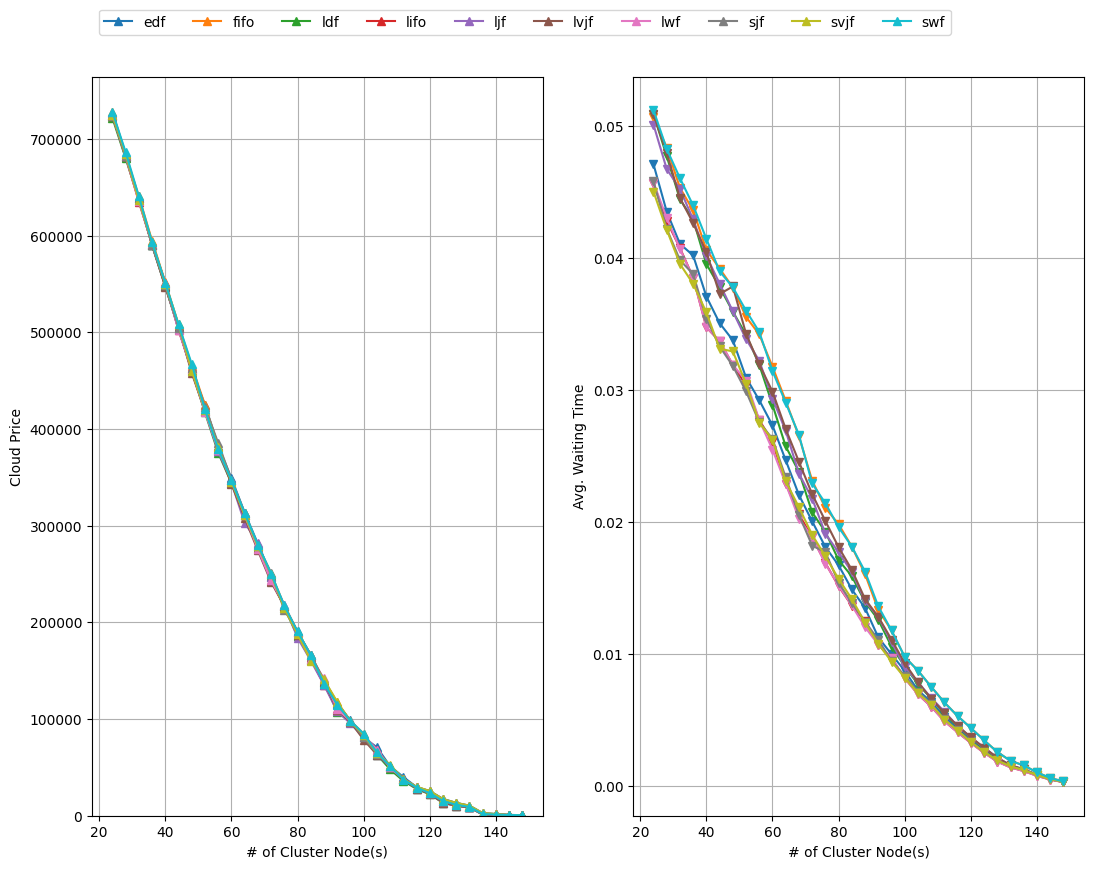

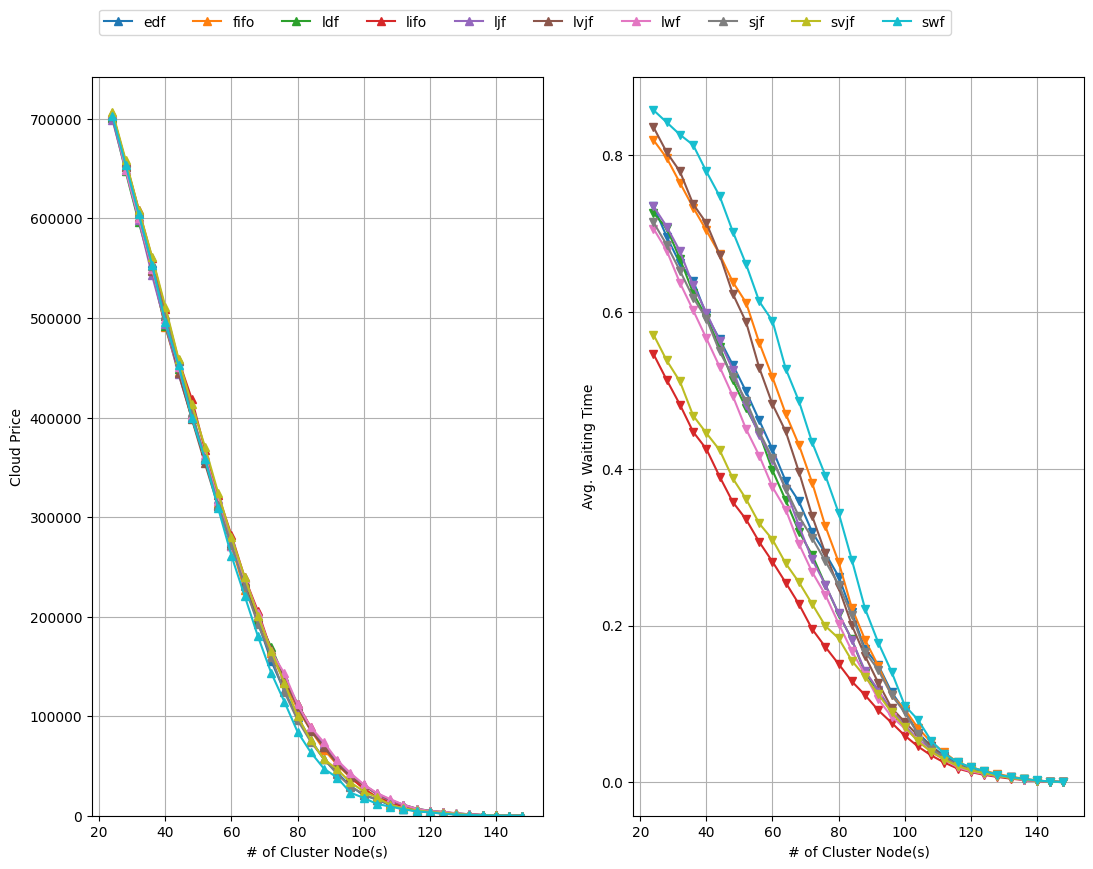

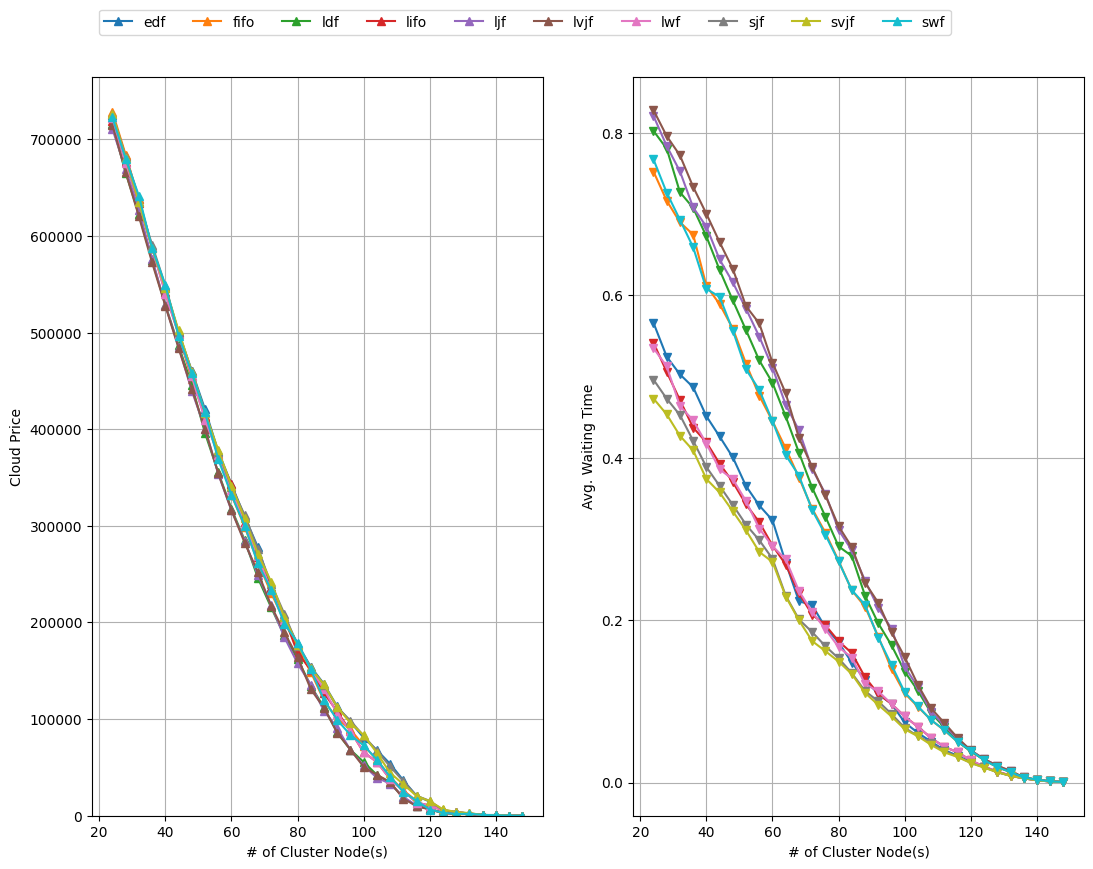

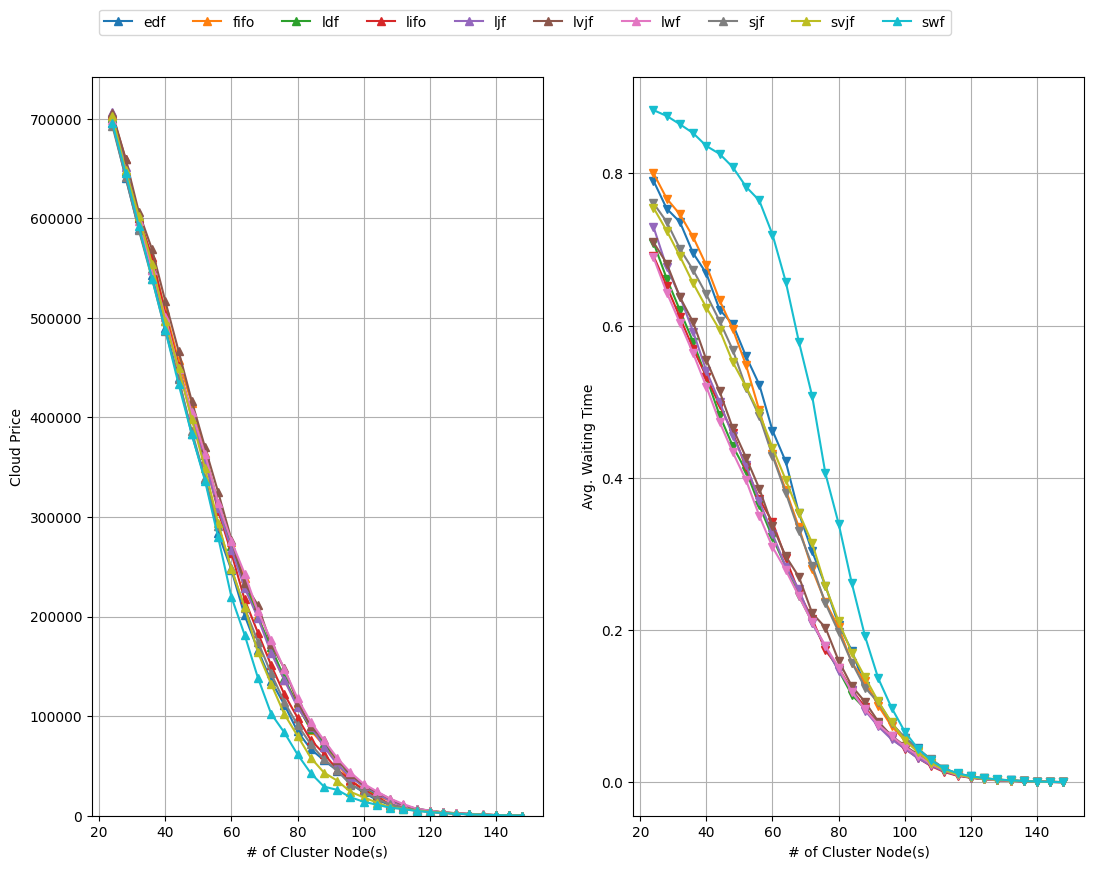

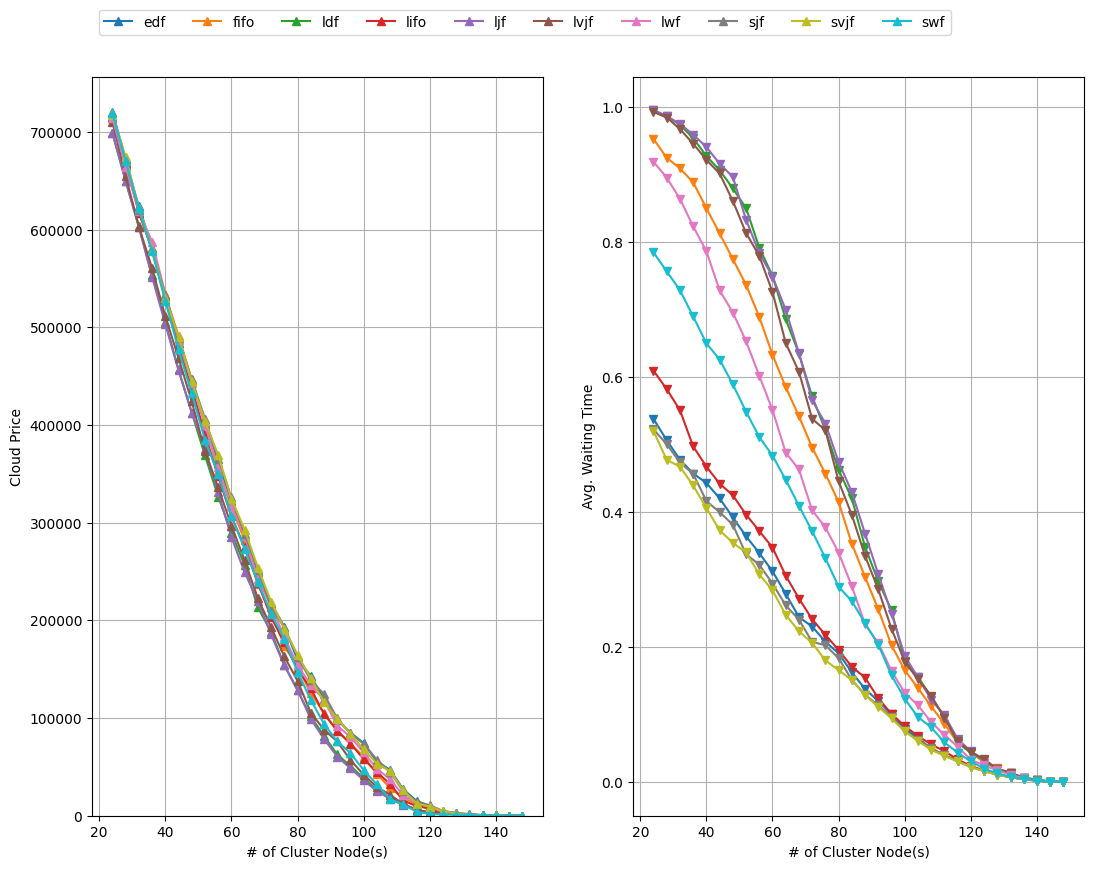

In [5]:

hybrid_results={}
hybrid_results_df = pd.DataFrame()

file = open(f'logs/cap/cap_philly_0.25_cont.log', 'rb')
hybrid_results['cap'] = pickle.load(file)
temp_df = create_results_df(hybrid_results['cap'], waiting_policy='cap')
plot_cost_and_waiting_graph(temp_df, normalized=False, plot_twin=False)
hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)


file = open(f'logs/base/vjw_philly_1.25_cont.log', 'rb')
hybrid_results['linear'] = pickle.load(file)
temp_df = create_results_df(hybrid_results['linear'], waiting_policy='linear')
plot_cost_and_waiting_graph(temp_df, normalized=False, plot_twin=False)
hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)

file = open(f'logs/constant/constant_philly_1_cont.log', 'rb')
hybrid_results['constant'] = pickle.load(file)
temp_df = create_results_df(hybrid_results['constant'], waiting_policy='constant')
plot_cost_and_waiting_graph(temp_df, normalized=False, plot_twin=False)
hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)


file = open(f'logs/area/area_philly_0.08_cont.log', 'rb')
hybrid_results['area'] = pickle.load(file)
temp_df = create_results_df(hybrid_results['area'], waiting_policy='area')
plot_cost_and_waiting_graph(temp_df, normalized=False, plot_twin=False)
hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)


file = open(f'logs/capacity/capacity_philly_0.8_cont.log', 'rb')
hybrid_results['capacity'] = pickle.load(file)
temp_df = create_results_df(hybrid_results['capacity'], waiting_policy='capacity')
plot_cost_and_waiting_graph(temp_df, normalized=False, plot_twin=False)
hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)

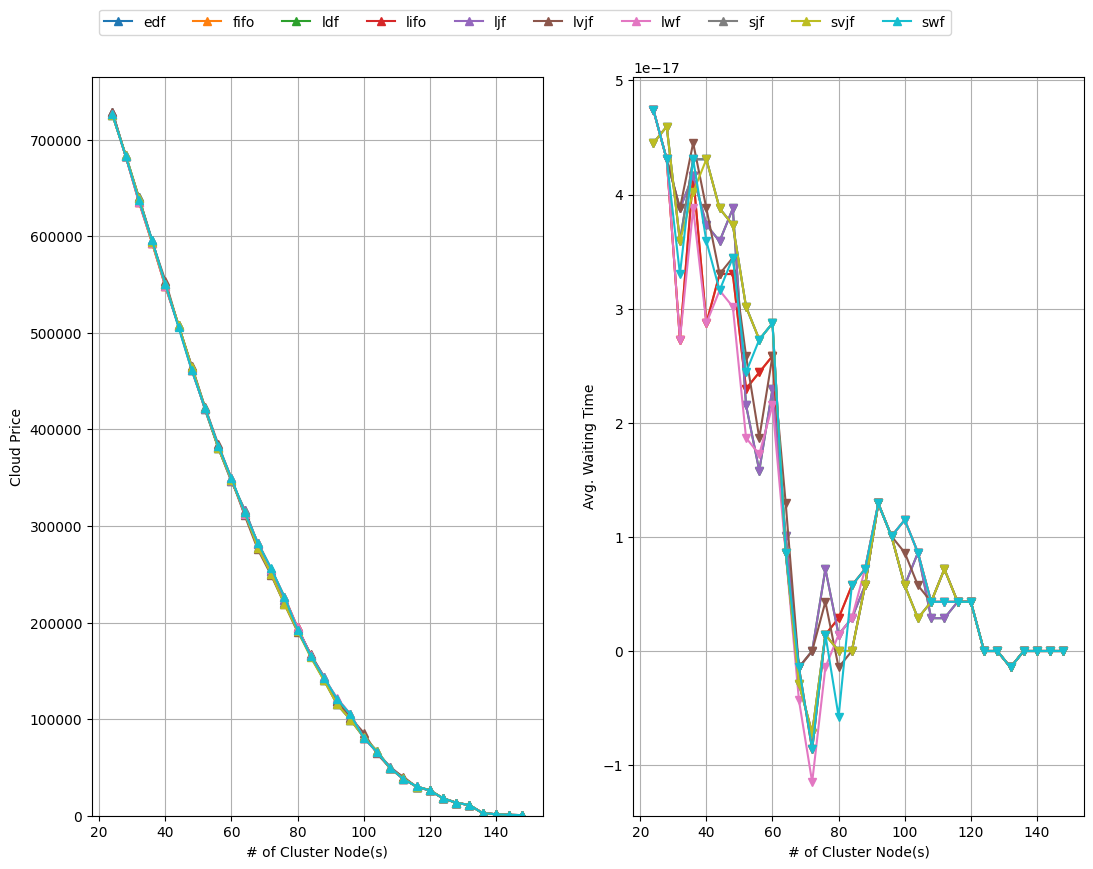

In [48]:
file = open(f'logs/base/vjw_philly_1_cont.log', 'rb')
hybrid_results['nowait'] = pickle.load(file)
temp_df = create_results_df(hybrid_results['nowait'], waiting_policy='nowait')
plot_cost_and_waiting_graph(temp_df, normalized=False, plot_twin=False)
hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)

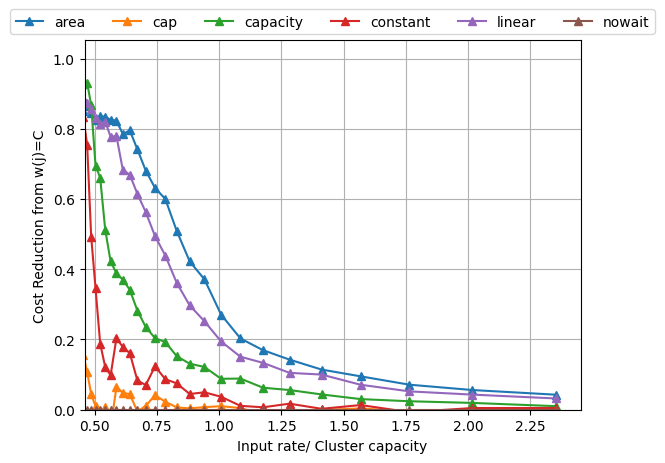

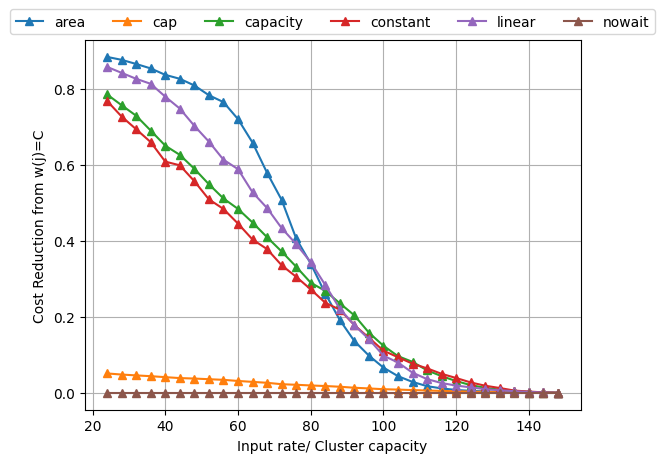

In [59]:
def plot_cost_mult_deadline(results_df, alg='swf', normalized=False):
    fig, ax = plt.subplots()
    results_df = results_df[results_df['alg'] == alg]
    
    constant_df = results_df[results_df['waiting_policy'] == 'nowait']
    
    diff_df = pd.merge(constant_df,
               results_df, left_on=['alg', 'size'],right_on=['alg', 'size'])
    
    title = 'Cost Reduction from w(j)=C'
    total_job_gpu_hours = 1155998.77277777
    job_makespan = 2559.3205555555555
    label_x = 'Input rate/ Cluster capacity'
    diff_df['cost_diff'] = (diff_df['cost_x'] - diff_df['cost_y'])/diff_df['cost_x']
    diff_df['x_axis'] = total_job_gpu_hours/(job_makespan*diff_df['size']*8)

    for idx, (label, grp) in enumerate(diff_df.groupby('waiting_policy_y')):
        a1 = grp.plot(x = 'x_axis', y = 'cost_diff',ax = ax, marker='^', label = label, legend=None, xlabel=label_x, \
                ylabel=title)

    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 0.95, 1, 0.2), loc="center")
    ax.grid(True, which='both')
    ax.set_xlim(left=0.46)
    ax.set_ylim(bottom=0.0)
    plt.show()
    
    fig, ax = plt.subplots()
    for idx, (label, grp) in enumerate(diff_df.groupby('waiting_policy_y')):
        a1 = grp.plot(x = 'size', y = 'waiting_time_y',ax = ax, marker='^', label = label, legend=None, xlabel=label_x, \
                ylabel=title)

    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 0.95, 1, 0.2), loc="center")
    ax.grid(True, which='both')
    #ax.set_xlim(left=0.46)
    $ax.set_ylim(bottom=0.0)
    plt.show()

#plot_cost_mult_deadline(hybrid_results_df, alg='fifo')

plot_cost_mult_deadline(hybrid_results_df, alg='swf')

/tmp/ipykernel_53799/1946575147.py:16: RuntimeWarning: invalid value encountered in scalar divide
  y_values = [(latex_formula(r, c, mu, tau=0) - latex_formula(r, c, mu, tau=tau))/latex_formula(r, c, mu, tau=0)  for r in r_values]


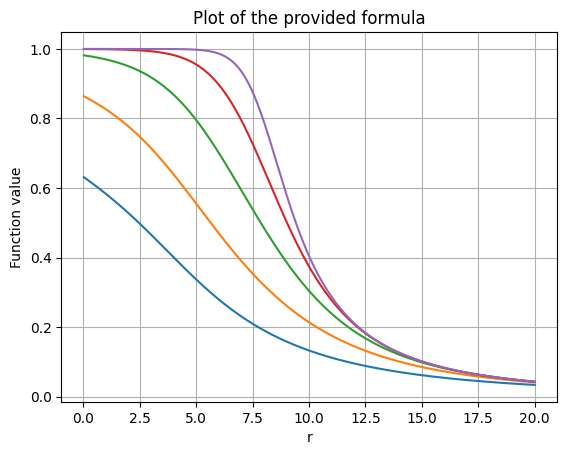

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

def latex_formula(r, c, mu, tau):
    numerator = (r**c / factorial(c)) * np.exp(-mu * tau * (c - r))
    denominator_sum = sum([(r**k / factorial(k)) for k in range(c)])
    last_term = (r**c / factorial(c)) * (r * np.exp(-mu * tau * (c - r)) - c) / (r - c)
    denominator = denominator_sum + last_term
    return numerator / denominator

c = 8
mu = 0.25
r_values = np.linspace(0, 20, 1000)
for tau in [0.5, 1, 2, 4, 8]:
    y_values = [(latex_formula(r, c, mu, tau=0) - latex_formula(r, c, mu, tau=tau))/latex_formula(r, c, mu, tau=0)  for r in r_values]

    plt.plot(r_values, y_values)
plt.xlabel('r')
plt.ylabel('Function value')
plt.title('Plot of the provided formula')
plt.grid()
plt.show()

In [41]:
asdf = hybrid_results['linear']

dict_keys(['cap', 'linear', 'constant', 'area', 'capacity'])